# Neo4J v057 test1 - Trellis : Coherence check results (QC)

Coherence check includes results generated by FastQC, Samtools Flagstat, and RTG Vcfstats.

In [2]:
from io import StringIO

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import google.datalab.bigquery as bq

# FastQC Results (n=288)

## Bigquery table (FastQC)

In [3]:
mvp_fastqc_table="gbsc-gcp-project-mvp-test.mvp_wgs35.fastqc"

## Per base quality

Inserted aggregation function (Average) for per base quality of each sample based on the FastQC results of 25 chromosomes

In [4]:
per_base_qual = bq.Query('SELECT index, value_tenth, ' +
                         'COUNT(*) AS observations ' +
                         'FROM (SELECT sample, index, ' +
                         'ROUND((CAST(value AS FLOAT64)), 1) AS value_tenth, ' +
                         'FROM `' + mvp_fastqc_table + '` ' +
                         'WHERE dimension = "per_base_qual") ' +
                         'GROUP BY index, value_tenth').execute().result().to_dataframe()
#per_base_qual.head()

In [5]:
per_base_qual.head()

,index,value_tenth,observations
0,1,29.8,194
1,1,29.9,41
2,1,29.7,22
3,1,29.6,1
4,1,29.4,1


Divided start point and end point of base quality index  <br />
Changed data type from string to num  <br />
Added log_observation

In [6]:
start_end = pd.DataFrame(per_base_qual['index'].str.split('-',1).tolist(), columns=['start', 'end'])
per_base_qual = per_base_qual.join(start_end)

per_base_qual[['value_tenth']] = per_base_qual[['value_tenth']].apply(pd.to_numeric)
per_base_qual[['start']] = per_base_qual[['start']].apply(pd.to_numeric)
per_base_qual[['observations']] = per_base_qual[['observations']].apply(pd.to_numeric)

per_base_qual[['log_observations']] = np.log(per_base_qual[['observations']])
#per_base_qual.head()
#per_base_qual.to_csv('per_base_qual.csv', sep='\t')

Distribution of per base quality

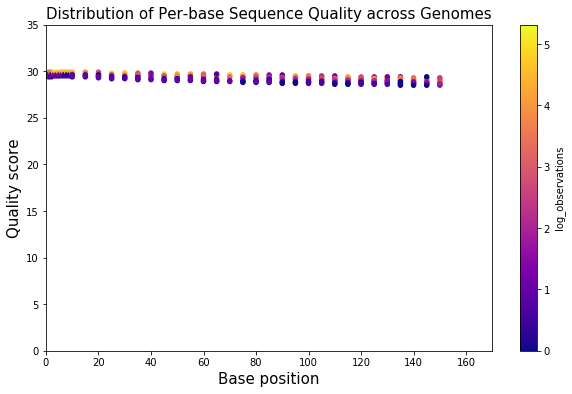

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
scat = per_base_qual.plot(kind='scatter', x='start', y='value_tenth', c='log_observations', cmap='plasma', ax=ax)
ax.set_xlim(0,170)
ax.set_ylim(0,35)
ax.set_title("Distribution of Per-base Sequence Quality across Genomes", size=15)
ax.set_xlabel("Base position", size=15)
ax.set_ylabel("Quality score", size=15)
plt.show()

## GC Content

gc_content value

In [8]:
dimension = "gc_content"
gc_content = bq.Query('SELECT sample, CAST(value as INT64) AS GC_value ' + 
                      'FROM `' + mvp_fastqc_table + '` ' +
                      'WHERE dimension = "' + dimension + '"' ).execute().result().to_dataframe()
display(gc_content.shape[0])
#gc_content.head()

263

Distribution of GC content

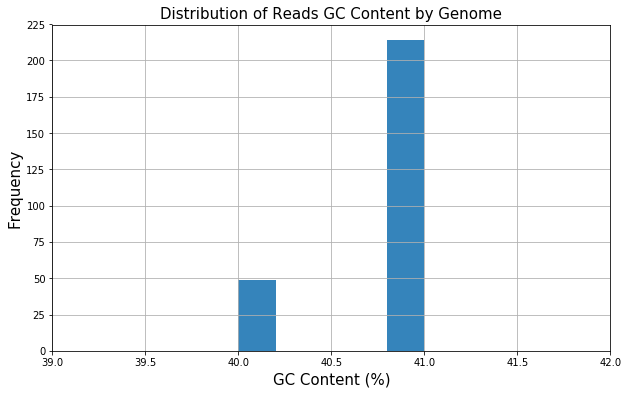

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
gc_content.hist(alpha=0.9, ax=ax, bins=5)
ax.set_xlim(39,42)
#ax.set_ylim(0,250)
ax.set_title("Distribution of Reads GC Content by Genome",size=15)
ax.set_xlabel("GC Content (%)",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Average sequence quality

sum seq_quality

In [10]:
dimension = "seq_quality"
avg_seq_qual = bq.Query('SELECT sample, ' +
                        'SUM(CAST(index as INT64) * CAST(value AS FLOAT64))/SUM(CAST(value AS FLOAT64)) ' + 
                        'FROM `' + mvp_fastqc_table + '` ' + 
                        'WHERE dimension = "' + dimension + '" ' +
                        'GROUP BY sample').execute().result().to_dataframe()

#print(avg_seq_qual.head())

statistics of average sequence quality

In [11]:
print('Mean of sequence quality: {0:0.2f}'.format(np.mean(avg_seq_qual.f0_)))
print('Median of sequence quality: {0:0.2f}'.format(np.median(avg_seq_qual.f0_)))
print('STD of sequence quality: {0:0.2f}'.format(np.std(avg_seq_qual.f0_)))
#avg_seq_qual.head()
#avg_seq_qual.shape[0]

Mean of sequence quality: 29.01
Median of sequence quality: 29.04
STD of sequence quality: 0.12


In [12]:
#plt.figure()
#plt.boxplot(avg_seq_qual['f0_'], 0, 'gD')
#plt.show()

Distribution of average sequence quality

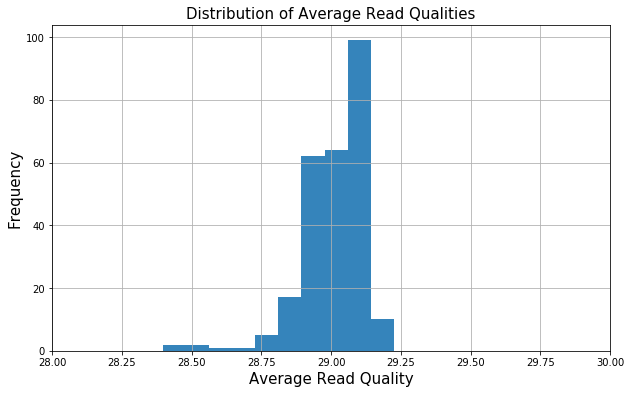

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
avg_seq_qual.hist(alpha=0.9, ax=ax)
ax.set_xlim(28,30)
ax.set_title("Distribution of Average Read Qualities",size=15)
ax.set_xlabel("Average Read Quality",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Sequence length

In [14]:
dimension = "seq_len"
seq_len = bq.Query('SELECT sample, dimension, ' +
                   'CAST(value AS INT64) as value '
                   'FROM `' + mvp_fastqc_table + '` ' + 
                   'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
#seq_len.head()
#seq_len.shape[0]

In [15]:
seq_len_counts = seq_len.groupby('value')['sample'].nunique()
#print (seq_len_counts)

Distribution of sequence length

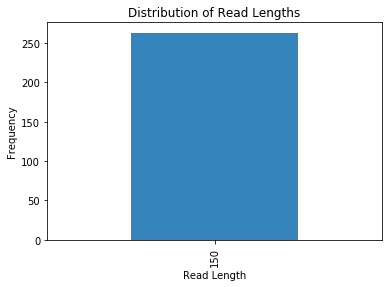

In [16]:
fig, ax = plt.subplots()
bar = seq_len_counts.plot.bar(alpha=0.9)
ax.set_title("Distribution of Read Lengths")
ax.set_xlabel("Read Length")
ax.set_ylabel("Frequency")
plt.show()

# VCFStats Results (n=288)

### Bigquery table

In [17]:
mvp_vcfstats_table = "gbsc-gcp-project-mvp-test.mvp_wgs35.vcfstats"

## SNPs per genome

The number of samples <br />

In [18]:
snps = bq.Query('SELECT sample, dimension, ' +
                'CAST(value AS INT64) as value ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension = "snps" ').execute().result().to_dataframe()
#print(snps.head())
print('The number of samples: '+str(snps.shape[0]))

The number of samples: 262


Statistics : mean, std, outliers

In [19]:
std=snps.value.std()
mean=snps.value.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
snps['Outlier'] = snps.value.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(snps[snps.Outlier].shape[0]))
print(snps[snps.Outlier])

mean: 4562867.12,  std: 378327.83
The number of outliers: 1
        sample dimension    value  Outlier
0  SHIP5125869      snps  3208146     True


Distribution of SNPs

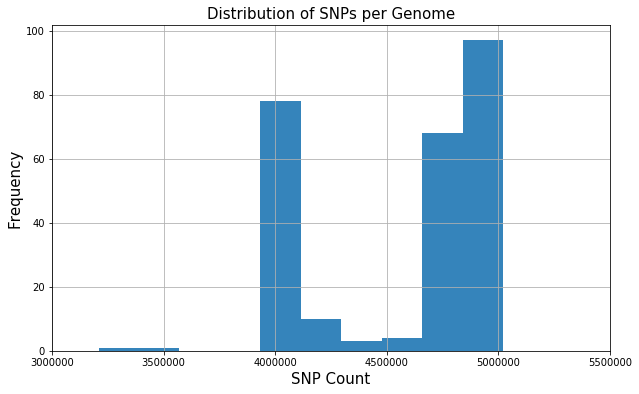

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
hist = snps.value.hist(alpha=0.9, ax=ax, bins=10)
ax.set_xlim(3000000,5500000)
ax.set_title("Distribution of SNPs per Genome",size=15)
ax.set_xlabel("SNP Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()
#plt.savefig('Distribution of SNPs per Genome.png')

## Check number of variants in each category

In [21]:
dimension_sums = bq.Query('SELECT dimension, SUM(CAST(value AS INT64)) AS sum ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension IN ("failed_filters", "passed_filters") ' +
                'GROUP BY dimension').execute().result().to_dataframe()
dimension_sums.head()

,dimension,sum
0,failed_filters,0
1,passed_filters,129415065280


## Indels per genome

In [22]:
dimension1 = "indels"
dimension2 = "insertions"
dimension3 = "deletions"

indels = bq.Query('SELECT sample, ' +
                  'SUM(CAST(value AS INT64)) as value ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE (dimension = "' + dimension1 + '") OR (dimension = "' + dimension2 + '") OR (dimension = "' + dimension3 + '")' +
                  'GROUP BY sample').execute().result().to_dataframe()
#indels.head()

In [23]:
#fig, ax = plt.subplots()
#hist = indels.hist(alpha=0.5, ax=ax)
#ax.set_title("Distribution of INDELs per Genome")
#ax.set_xlabel("INDEL Count")
#ax.set_ylabel("Frequency")
#plt.show()

In [24]:
#box = indels.plot.box()

In [25]:
#plt.figure()
#plt.boxplot(indels['value'], 0, 'gD')
#plt.show()

## Cumulative insertions, deletions, and indels
RTG Tools vcfstats outputs data on three categories of indels: insertions, deletions, and indels. From this google group post (https://groups.google.com/a/realtimegenomics.com/forum/#!searchin/rtg-users/vcfstats/rtg-users/-eFsSbWF6ks/1HrnevHTAgAJ):

>For the insertions/deletions/indels the table is based on the delta in length rather than total length (which really matters for the indels):

>Insertions (pure addition of bases)
>A -> AT (length 1 insertion)
>ATT -> ATTTT (length 2 insertion) 

>Deletions (pure deletion of bases)
>AT -> A (length 1 deletion)
>ATTTT -> ATT (length 2 deletion)

>Indels (length changing but not pure)
>ATT -> CTTT (length 1 indel)
>CTTT -> ATT (length 1 indel)"

In [26]:
indels = bq.Query('SELECT sample, SUM(DISTINCT CAST(value AS INT64)) AS cum_indels ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE dimension = "insertions" ' +
                  'OR dimension = "deletions" ' +
                  'OR dimension = "indels" ' +
                  'GROUP BY sample').execute().result().to_dataframe()
#indels.head()

Statistics : mean, std, outliers

In [27]:
std=indels.cum_indels.std()
mean=indels.cum_indels.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
indels['Outlier'] = indels.cum_indels.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(indels[indels.Outlier].shape[0]))
print(indels[indels.Outlier])

mean: 1055282.66,  std: 80316.72
The number of outliers: 1
         sample  cum_indels  Outlier
81  SHIP5125869      802787     True


Distribution of indels

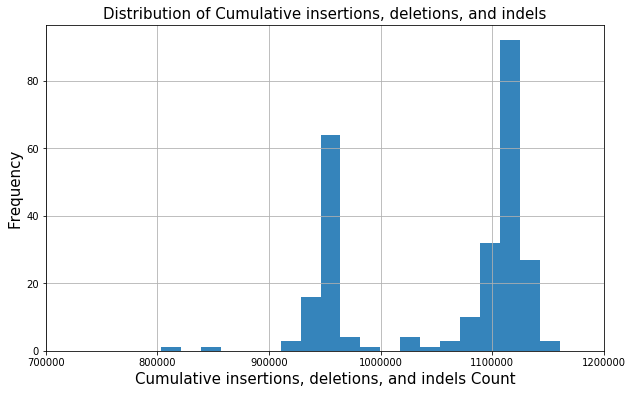

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
hist = indels.cum_indels.hist(alpha=0.9, ax=ax, bins = 20)
ax.set_xlim(700000,1200000)
ax.set_title("Distribution of Cumulative insertions, deletions, and indels",size=15)
ax.set_xlabel("Cumulative insertions, deletions, and indels Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Frequency of Ti/Tv ratios

In [48]:
dimension = "ti_tv_ratio"
ti_tv = bq.Query('SELECT sample, dimension, ' + 
                 'CAST(value AS FLOAT64) as value ' + 
                 'FROM `' + mvp_vcfstats_table + '` ' + 
                 'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
#ti_tv.head()
np.mean(ti_tv.value)

1.940992366412214

Distribution of Ti/Tv

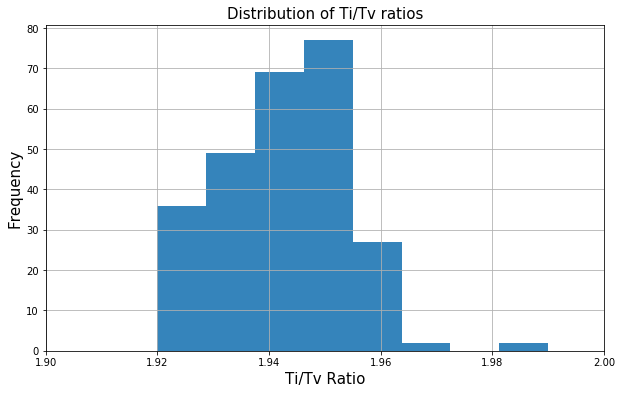

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
hist = ti_tv.hist(alpha=0.9, ax=ax, bins=8)
ax.set_xlim(1.9,2.0)
ax.set_title("Distribution of Ti/Tv ratios",size=15)
ax.set_xlabel("Ti/Tv Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

In [31]:
#plt.figure()
#plt.boxplot(ti_tv['value'], 0, 'gD')
#plt.show()

## Frequency of SNP het/hom ratios

In [32]:
snp_het_hom_ratio = bq.Query('SELECT sample, dimension, ' + 
                             'CAST(value AS FLOAT64) as value ' + 
                             'FROM `' + mvp_vcfstats_table + '` ' + 
                             'WHERE dimension = "snp_het_hom_ratio"').execute().result().to_dataframe()
#snp_het_hom_ratio.head()

Statistics : mean, std, outliers

In [33]:
std=snp_het_hom_ratio.value.std()
mean=snp_het_hom_ratio.value.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
snp_het_hom_ratio['Outlier'] = snp_het_hom_ratio.value.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(snp_het_hom_ratio[snp_het_hom_ratio.Outlier].shape[0]))
print(snp_het_hom_ratio[snp_het_hom_ratio.Outlier])

mean: 1.95,  std: 0.23
The number of outliers: 2
        sample          dimension  value  Outlier
0  SHIP5125869  snp_het_hom_ratio   0.96     True
1  SHIP5125862  snp_het_hom_ratio   1.21     True


Distribution of SNP het/hom

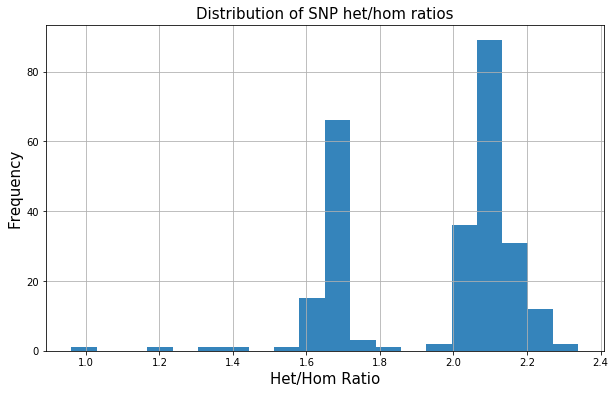

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
hist = snp_het_hom_ratio.value.hist(alpha=0.9, ax=ax, bins=20)
ax.set_title("Distribution of SNP het/hom ratios",size=15)
ax.set_xlabel("Het/Hom Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

# Samtools Flagstat Results (n=288)

In [35]:
mvp_flagstat_table = "gbsc-gcp-project-mvp-test.mvp_wgs35.flagstat"

## Count and Percent of reads mapped to reference

In [36]:
dimension = "qc_passed_reads_count"
qc_passed_reads_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as total_count, ' +
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
print('The number of samples: '+str(qc_passed_reads_count.shape[0]))

The number of samples: 262


In [37]:
dimension = "mapped_reads_count"
mapped_reads_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as mapped_count ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()

In [38]:
mapped_reads_perc=qc_passed_reads_count.set_index(['sample']).join(mapped_reads_count.set_index(['sample']))
mapped_reads_perc['mapped_perc']=100*(mapped_reads_perc['mapped_count']/mapped_reads_perc['total_count'])
mapped_reads_perc['total_count']=mapped_reads_perc.total_count.astype(int)
mapped_reads_perc['mapped_count']=mapped_reads_perc.mapped_count.astype(int)
mapped_reads_perc['mapped_perc']=mapped_reads_perc.mapped_perc.astype(float).round(2)

#print('Mean of mapped_reads: {0:0.2f}'.format(np.mean(mapped_reads_perc.mapped_perc)))
#print('Median of mapped_reads: {0:0.2f}'.format(np.median(mapped_reads_perc.mapped_perc)))
#print('STD of mapped_reads: {0:0.2f}'.format(np.std(mapped_reads_perc.mapped_perc)))
#mapped_reads_perc.head()

Statistics : Mean, STD, the number of samples with less than 99% mapped percent 

In [39]:
std=mapped_reads_perc.mapped_perc.std()
mean=mapped_reads_perc.mapped_perc.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
#mapped_reads_perc['Outlier'] = mapped_reads_perc.mapped_perc.apply(lambda x: False if abs(mean-x)<3*std else True)
mapped_reads_perc['Outlier'] = mapped_reads_perc.mapped_perc.apply(lambda x: False if x > 98 else True)

print('The number of samples in < 98% : {0}'.format(mapped_reads_perc[mapped_reads_perc.Outlier].shape[0]))
#print('The number of outlier samples : {0}'.format(mapped_reads_perc[mapped_reads_perc.Outlier].shape[0]))
print(mapped_reads_perc[mapped_reads_perc.Outlier])

mapped_count_outlier = mapped_reads_perc[['mapped_perc','Outlier']]
mapped_count_outlier.sort_values(by=['mapped_perc'],inplace=True)
#print(mapped_count_outlier[mapped_count_outlier.Outlier])

mean: 99.81,  std: 0.02
The number of samples in < 98% : 0
Empty DataFrame
Columns: [total_count, mapped_count, mapped_perc, Outlier]
Index: []


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Distribution of Mapped Reads

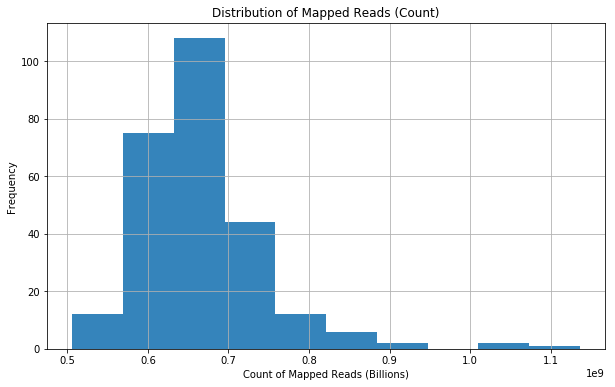

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
hist = mapped_reads_perc.mapped_count.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (Count)")
ax.set_xlabel("Count of Mapped Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

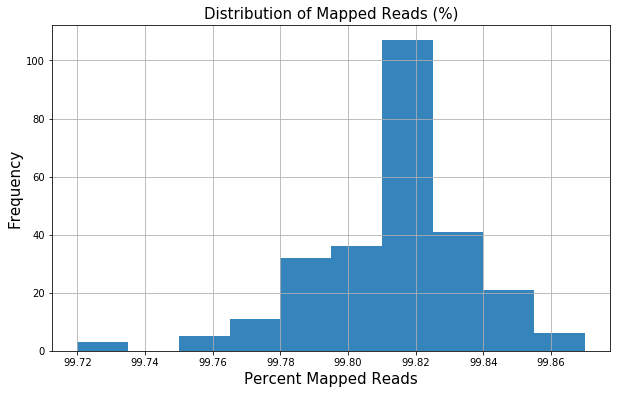

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
hist = mapped_reads_perc.mapped_perc.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (%)",size=15)
ax.set_xlabel("Percent Mapped Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Count and Percent of reads properly paired

In [42]:
dimension = "properly_paired_count"
properly_paired_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as mapped_count ' 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()


In [43]:
properly_paired_perc=qc_passed_reads_count.set_index(['sample']).join(properly_paired_count.set_index(['sample']))
properly_paired_perc['mapped_perc']=100*(properly_paired_perc['mapped_count']/properly_paired_perc['total_count'])
properly_paired_perc['total_count']=properly_paired_perc.total_count.astype(int)
properly_paired_perc['mapped_count']=properly_paired_perc.mapped_count.astype(int)
properly_paired_perc['mapped_perc']=properly_paired_perc.mapped_perc.astype(float).round(2)

#print('Mean of properly_paired: {0:0.2f}'.format(np.mean(properly_paired_perc.mapped_perc)))
#print('Median of properly_paired: {0:0.2f}'.format(np.median(properly_paired_perc.mapped_perc)))
#print('STD of properly_paired: {0:0.2f}'.format(np.std(properly_paired_perc.mapped_perc)))
#properly_paired_perc.head()

Statistics : Mean, STD, the number of samples with less than 96% properly paired percent 

In [44]:
std=properly_paired_perc.mapped_perc.std()
mean=properly_paired_perc.mapped_perc.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
# properly_paired_perc['Outlier'] = properly_paired_perc.mapped_perc.apply(lambda x: False if abs(mean-x)<3*std else True)
properly_paired_perc['Outlier'] = properly_paired_perc.mapped_perc.apply(lambda x: False if x > 96 else True)
display(properly_paired_perc.head())
properly_paired_perc = properly_paired_perc[['mapped_count','mapped_perc','Outlier']]
properly_paired_perc.sort_values(by=['mapped_perc'],inplace=True)
print('The number of samples in < 96% : {0}'.format(properly_paired_perc[properly_paired_perc.Outlier].shape[0]))
print(properly_paired_perc[properly_paired_perc.Outlier])

mean: 96.74,  std: 0.23


,total_count,mapped_count,mapped_perc,Outlier
sample,,,,
SHIP4962319,652546033,630292021,96.59,False
SHIP4962329,627277385,606584496,96.70,False
SHIP5119435,603828823,582679455,96.50,False
SHIP4962325,648667054,626516495,96.59,False
SHIP5119433,622440583,602755371,96.84,False


The number of samples in < 96% : 1
             mapped_count  mapped_perc  Outlier
sample                                         
SHIP5141894     703416651        95.98     True


Distribution of properly paired reads

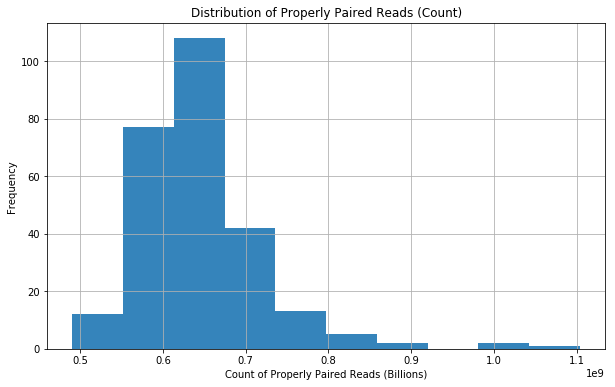

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
hist = properly_paired_perc.mapped_count.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (Count)")
ax.set_xlabel("Count of Properly Paired Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

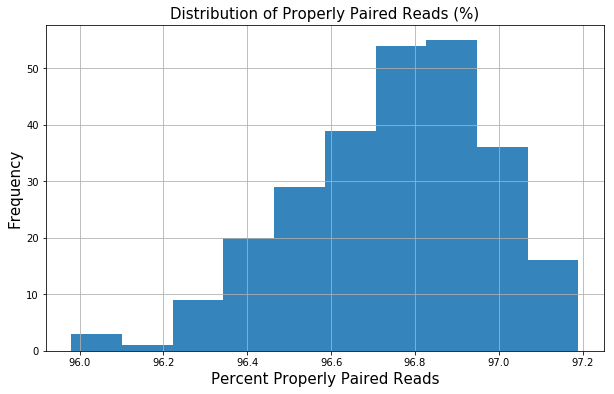

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
hist = properly_paired_perc.mapped_perc.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (%)",size=15)
ax.set_xlabel("Percent Properly Paired Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()